# Demo of e-valuator

In this notebook, we demonstrate how to use our package to apply to a dataset (MATH) for early terminatations/token saving. We require the user to input a (calibration) dataframe of agent trajectories with the following columns:

* `uq_problem_idx`: A unique identifier for each problem. Multiple rows will correspond to the same trajectory, so this is an identifier of the problem.
* `num_steps`: Number of steps taken in the trajectory thus far.
* `judge_probability`: Verifier score for that step in that trajectory.
* `solved`: A binary indicator (0/1) of whether that problem was (eventually) solved by the agent. This column is only required during calibration time.

You may use different names for the columns, in which case you'll have to specify in your function arguments the variable names. For instance, you'd have to change the `prob_col`, `problem_col`, and `step_col` arguments of this function:

```
add_judge_probability_series(
    df: pd.DataFrame,
    prob_col: str = "judge_probability",
    problem_col: str = "problem_idx",
    step_col: str = "num_steps",
)
```

Here we also track the tokens generated per step in a column `generated_tokens` in the test dataframe.

Note: the judge/verifier used in `math_cleaned_w_scores.csv` was Mistral-7b-prm (https://huggingface.co/peiyi9979/math-shepherd-mistral-7b-prm), and the agent used was Claude with reasoning.
Let's get started!


In [40]:
import pandas as pd
import numpy as np

## import the package
from evaluator import EValuator
from evaluator.utils import add_judge_probability_series

# csv_path = "/data2/shuvom/shuvom/repo/data/hotpotqa_cleaned_w_scores.csv"
csv_path = "../../data/math_cleaned_w_scores.csv"
# csv_path = "/data2/shuvom/shuvom/repo/data/hotpotqa_combined_df.csv"

In [ ]:
## load in the raw data
df = pd.read_csv(csv_path)

print("Loaded:", df.shape)
print(df.columns)



## add a column of concatenated verifier scores
## note: this step takes some time
df = add_judge_probability_series(df)
df.head()


Loaded: (40190, 5)
Index(['uq_problem_idx', 'num_steps', 'judge_probability', 'solved',
       'generated_tokens'],
      dtype='object')


Building judge_probability_series:   0%|          | 0/40190 [00:00<?, ?it/s]

Building judge_probability_series:  17%|█▋        | 6891/40190 [00:17<01:22, 404.28it/s]

Now that we have our dataframe set up, let's split it into calibration and test set. In general, you can load in different dataframes for calibration and test, but in this notebook we generate them as splits of the same set. Note that a single problem must be fully in either test or calibration (e.g., no instances where steps 1-2 are in calibration and 3-4 are in test).

In [ ]:
## get list of all unique problem indices
unique_ids = df["uq_problem_idx"].unique()
rng = np.random.default_rng(42)

# 80/20 split of calibration and test set
n_cal = int(0.8 * len(unique_ids))
cal_ids = rng.choice(unique_ids, size=n_cal, replace=False)
test_ids = np.setdiff1d(unique_ids, cal_ids)


## split into calibration and test set
cal_df = df[df["uq_problem_idx"].isin(cal_ids)].reset_index(drop=True)
test_df = df[df["uq_problem_idx"].isin(test_ids)].reset_index(drop=True)

print("Calibration:", cal_df.shape, "Unique problems:", len(cal_ids))
print("Test:", test_df.shape, "Unique problems:", len(test_ids))


Calibration: (32164, 6) Unique problems: 4000
Test: (8026, 6) Unique problems: 1000


In [ ]:
cal_df

,uq_problem_idx,num_steps,judge_probability,solved,generated_tokens,judge_probability_series
0,algebra_1,1,0.994891,1,6,[0.994890570640564]
1,algebra_1,2,0.996114,1,11,"[0.994890570640564, 0.9961143732070924]"
2,algebra_1,3,0.969394,1,6,"[0.994890570640564, 0.9961143732070924, 0.9693..."
3,algebra_1,4,0.984225,1,11,"[0.994890570640564, 0.9961143732070924, 0.9693..."
4,algebra_1,5,0.978769,1,14,"[0.994890570640564, 0.9961143732070924, 0.9693..."
...,...,...,...,...,...,...
32159,precalculus_545,5,0.537830,1,9,"[0.5542598366737366, 0.4456803202629089, 0.567..."
32160,precalculus_545,6,0.544261,1,19,"[0.5542598366737366, 0.4456803202629089, 0.567..."
32161,precalculus_545,7,0.465011,1,7,"[0.5542598366737366, 0.4456803202629089, 0.567..."
32162,precalculus_545,8,0.441927,1,23,"[0.5542598366737366, 0.4456803202629089, 0.567..."


Now we'll fit our density ratio estimators. By default, we recommend logistic regression, which can be specified with `model_type="logistic"` as we do below. However, we also support random forests and plan to support other DRE methods in the future. You may also modify `evaluator.py` to change the density ratio estimation procedure (e.g., add L2 penalty to the Logistic Regression).

In [ ]:
ev = EValuator(
    model_type="logistic",   
    mt_variant="both",    ## "split" is finite time/empirical version of e-valuator. "anytime" is the anytime-valid version. "both" adds both the finite-time and empirical versions as columns to the test set.
    alphas=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], ## by default, alphas = [0.05] unless otherwise specified, as we do here
    # delta=0.1, ## only used for split version, confidence level in false alarm guarantee. default is 0.1 (meaning 90% confidence in false alarm guarantee)
    delta=0.05,
)

ev


In [ ]:
ev.fit(cal_df)


In [ ]:
## apply the learned density ratio estimators to the test set
test_df = ev.apply(test_df)

In [ ]:
## let's look at at the statistics
## note anytime eval and split eval will be different because split eval splits the calibration set into two parts
test_df[["uq_problem_idx", "num_steps", "solved"] + [c for c in test_df.columns if "e_val" in c]]


,uq_problem_idx,num_steps,solved,anytime_e_val,split_e_val
0,algebra_0,1,1,0.510313,0.455151
1,algebra_0,2,1,0.455224,0.405951
2,algebra_0,3,1,0.417374,0.377953
3,algebra_0,4,1,0.405859,0.373614
4,algebra_0,5,1,0.391375,0.369716
...,...,...,...,...,...
8021,precalculus_542,6,0,35.102705,69.774875
8022,precalculus_542,7,0,34.780558,97.693689
8023,precalculus_542,8,0,34.013978,59.620218
8024,precalculus_542,9,0,38.006953,66.689336


## Tokens saved
Ok, we are done! Let's see how our e-valuator performed on this test set. How many tokens did we save?

In [ ]:
results_anytime = {}
results_split = {}

## Ensure that generated_tokens is present
if "generated_tokens" not in test_df.columns:
    raise KeyError("Column 'generated_tokens' is missing from test_df.")

## One label per problem
problem_solved = (
    test_df.groupby(ev.problem_col)["solved"]
           .max()
           .astype(int)
)

## How many tokens did we use for each problem?
tokens_per_problem_full = (
    test_df.groupby(ev.problem_col)["generated_tokens"]
           .sum()
)

baseline_total_tokens = tokens_per_problem_full.sum()
baseline_accuracy = problem_solved.mean()

print("=== Baseline (no early stopping) ===")
print(f"accuracy={baseline_accuracy:.4f} | total tokens={baseline_total_tokens}")


def compute_stats(prefix):
    out = {}
    for a in ev.alphas:
        base = str(a).replace(".", "_")
        col = f"{prefix}_alpha_{base}"

        if col not in test_df.columns:
            raise KeyError(f"Expected column '{col}' not found in test_df.")

        ## Find problems that ever trigger a rejection
        problem_reject = (
            test_df.groupby(ev.problem_col)[col]
                   .max()
                   .astype(bool)
        )
        terminated_problems = problem_reject[problem_reject].index
        non_terminated_problems = problem_reject[~problem_reject].index

        if len(terminated_problems) == 0:
            out[a] = {
                "accuracy": float(baseline_accuracy),
                "total_tokens": int(baseline_total_tokens),
            }
            continue

        ## Tokens for terminated problems: only up to first rejecting step
        total_tokens_stopped = 0
        for pid in terminated_problems:
            g = (
                test_df[test_df[ev.problem_col] == pid]
                .sort_values(ev.step_col)
            )

            ## First step where we reject
            reject_steps = g[g[col]].loc[:, ev.step_col]
            first_step = reject_steps.min()

            ## Tokens up to and including that step
            tokens = g[g[ev.step_col] <= first_step]["generated_tokens"].sum()
            total_tokens_stopped += tokens

        ## Tokens for non-terminated problems: full trajectory
        total_tokens_not_stopped = tokens_per_problem_full.loc[non_terminated_problems].sum()

        total_tokens = int(total_tokens_stopped + total_tokens_not_stopped)

        ## Overall accuracy after early stopping:
        ## - If a problem is terminated, it no longer counts as solved
        ## - Otherwise, keep the original solved label
        effective_solved = problem_solved.copy()
        effective_solved.loc[terminated_problems] = 0
        accuracy = float(effective_solved.mean())

        out[a] = {
            "accuracy": accuracy,
            "total_tokens": total_tokens,
        }

    return out


## Compute stats for anytime and split
results_anytime = compute_stats("reject_anytime")
results_split = compute_stats("reject_split")

print("\n=== Early-stopping policy (anytime) ===")
for a, stats in results_anytime.items():
    print(
        f"alpha={a:.3f} | "
        f"overall accuracy={stats['accuracy']:.4f} | "
        f"total tokens={stats['total_tokens']} | "
        f"total token percentage={stats['total_tokens']/baseline_total_tokens:.4f}" 
    )

print("\n=== Early-stopping policy (split) ===")
for a, stats in results_split.items():
    print(
        f"alpha={a:.3f} | "
        f"overall accuracy={stats['accuracy']:.4f} | "
        f"total tokens={stats['total_tokens']} | "
        f"total token percentage={stats['total_tokens']/baseline_total_tokens:.4f}" 
    )


=== Baseline (no early stopping) ===
accuracy=0.5790 | total tokens=93869

=== Early-stopping policy (anytime) ===
alpha=0.010 | overall accuracy=0.5790 | total tokens=93869 | total token percentage=1.0000
alpha=0.050 | overall accuracy=0.5780 | total tokens=92974 | total token percentage=0.9905
alpha=0.100 | overall accuracy=0.5740 | total tokens=91351 | total token percentage=0.9732
alpha=0.200 | overall accuracy=0.5590 | total tokens=87172 | total token percentage=0.9287
alpha=0.300 | overall accuracy=0.5410 | total tokens=83616 | total token percentage=0.8908
alpha=0.400 | overall accuracy=0.5170 | total tokens=80000 | total token percentage=0.8523
alpha=0.500 | overall accuracy=0.4950 | total tokens=74659 | total token percentage=0.7954

=== Early-stopping policy (split) ===
alpha=0.010 | overall accuracy=0.5780 | total tokens=93481 | total token percentage=0.9959
alpha=0.050 | overall accuracy=0.5620 | total tokens=88089 | total token percentage=0.9384
alpha=0.100 | overall accur

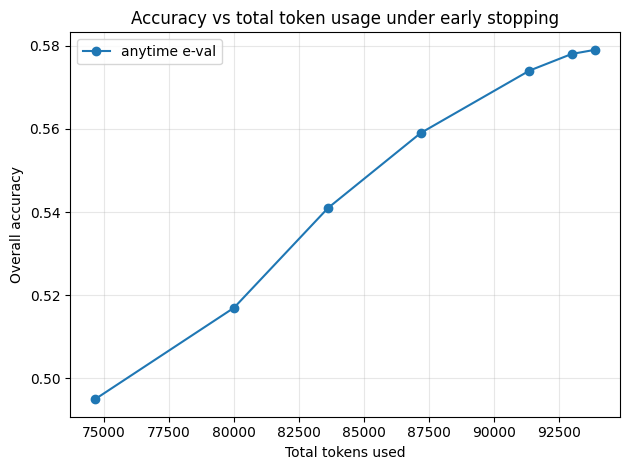

In [ ]:
import matplotlib.pyplot as plt

anytime_tokens = []
anytime_acc = []
for a in ev.alphas:
    acc, tokens = results_anytime[a]["accuracy"], results_anytime[a]["total_tokens"]
    anytime_tokens.append(tokens)
    anytime_acc.append(acc)

# Sort by tokens so curves look nice
# any_idx = np.argsort(anytime_tokens)


plt.plot(
    anytime_tokens,
    anytime_acc,
    marker="o",
    linestyle="-",
    label="anytime e-valuator",
)

plt.xlabel("Total tokens used")
plt.ylabel("Overall accuracy")
plt.title("Accuracy vs total token usage under early stopping")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## General power, false alarm statistics
Let's also look at the general statistics on false alarm and power.

Mean maximum among solved problems: 1.4917322893919933
Mean maximum among unsolved problems: 4.507899154013437


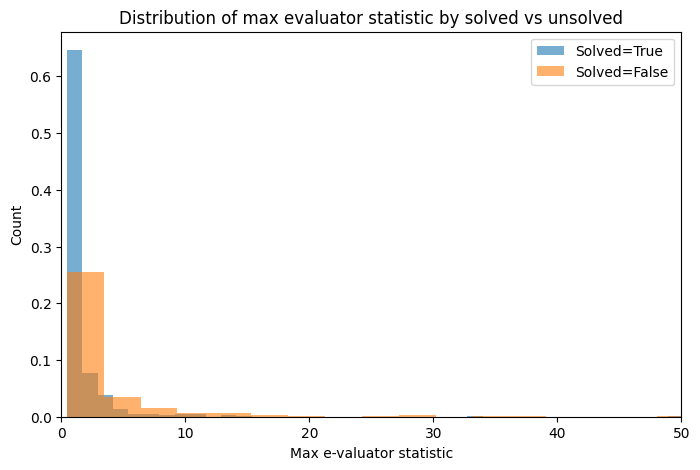

In [ ]:
import matplotlib.pyplot as plt

## let's use the empirical version
stat_col = "split_e_val"

grouped = test_df.groupby("uq_problem_idx")
problem_max = grouped[stat_col].max()
problem_solved = grouped["solved"].max()

max_solved = problem_max[problem_solved == 1]
max_unsolved = problem_max[problem_solved == 0]

print("Mean maximum among solved problems:", max_solved.mean())
print("Mean maximum among unsolved problems:", max_unsolved.mean())

plt.figure(figsize=(8,5))
plt.hist(max_solved, bins=40, alpha=0.6, label="Solved=True", density=True)
plt.hist(max_unsolved, bins=40, alpha=0.6, label="Solved=False", density=True)
plt.xlim(0, 50)
plt.xlabel("Max e-valuator statistic")
plt.ylabel("Count")
plt.title("Distribution of max evaluator statistic by solved vs unsolved")
plt.legend()
plt.show()


In [ ]:
results_anytime = {}
results_split = {}

## One label per problem
problem_solved = (
    test_df.groupby(ev.problem_col)["solved"]
           .max()
           .astype(int)
)

for a in ev.alphas:
    base = str(a).replace(".", "_")
    col_any = f"reject_anytime_alpha_{base}"
    col_split = f"reject_split_alpha_{base}"

    ## "Ever rejected" for each problem
    reject_any = (
        test_df.groupby(ev.problem_col)[col_any]
               .max()
               .astype(bool)
    )
    reject_split = (
        test_df.groupby(ev.problem_col)[col_split]
               .max()
               .astype(bool)
    )

    ## power: pr(reject|solved == 0)
    ## false alarm rate: pr(reject|solved == 1)
    power_any = reject_any[problem_solved == 0].mean()
    fa_any = reject_any[problem_solved == 1].mean()

    power_split = reject_split[problem_solved == 0].mean()
    fa_split = reject_split[problem_solved == 1].mean()

    results_anytime[a] = (power_any, fa_any)
    results_split[a] = (power_split, fa_split)

print("=== Problem-level Evaluation (anytime) ===")
for a, (power, fa) in results_anytime.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")

print("\n=== Problem-level Evaluation (split) ===")
for a, (power, fa) in results_split.items():
    print(f"alpha={a:.3f} | power={power:.4f} | false alarm rate={fa:.4f}")


=== Problem-level Evaluation (anytime) ===
alpha=0.010 | power=0.0000 | false alarm rate=0.0000
alpha=0.050 | power=0.0214 | false alarm rate=0.0017
alpha=0.100 | power=0.0618 | false alarm rate=0.0086
alpha=0.200 | power=0.1449 | false alarm rate=0.0345
alpha=0.300 | power=0.2138 | false alarm rate=0.0656
alpha=0.400 | power=0.3064 | false alarm rate=0.1071
alpha=0.500 | power=0.3919 | false alarm rate=0.1451

=== Problem-level Evaluation (split) ===
alpha=0.010 | power=0.0166 | false alarm rate=0.0017
alpha=0.050 | power=0.1235 | false alarm rate=0.0294
alpha=0.100 | power=0.2280 | false alarm rate=0.0708
alpha=0.200 | power=0.4442 | false alarm rate=0.1848
alpha=0.300 | power=0.6271 | false alarm rate=0.3005
alpha=0.400 | power=0.7173 | false alarm rate=0.3886
alpha=0.500 | power=0.7910 | false alarm rate=0.4888
